In [85]:
import cv2
import numpy as np

In [86]:
# 定义点类
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    # 计算点到点的距离
    def distance_to_point(self, other_point):
        dx = self.x - other_point.x
        dy = self.y - other_point.y
        return np.sqrt(dx * dx + dy * dy)


# 定义线段类
class Line:
    def __init__(self, start_point, end_point):
        self.start_point = start_point
        self.end_point = end_point

    # 计算线段的长度

    def get_length(self):
        dx = self.end_point.x - self.start_point.x
        dy = self.end_point.y - self.start_point.y
        return np.sqrt(dx * dx + dy * dy)

    # 判断两条线段是否相交
    def is_intersecting(self, other_line):
        # 计算两条线段的叉积
        cross_product = (self.end_point.x - self.start_point.x) * (other_line.end_point.y - other_line.start_point.y) - \
                        (self.end_point.y - self.start_point.y) * (other_line.end_point.x - other_line.start_point.x)

        # 如果叉积为 0，则两条线段平行或重叠
        if cross_product == 0:
            return False

        # 判断两条线段是否在同一条直线上
        if (self.start_point.x - other_line.start_point.x) * (self.end_point.y - other_line.end_point.y) == \
                (self.start_point.y - other_line.start_point.y) * (self.end_point.x - other_line.end_point.x):
            return False

        # 判断两条线段的端点是否在彼此的两侧
        return (self.is_on_the_left_side(other_line.start_point) ^ self.is_on_the_left_side(other_line.end_point)) and \
            (other_line.is_on_the_left_side(self.start_point) ^ other_line.is_on_the_left_side(self.end_point))

    # 判断点是否在线段的左侧
    def is_on_the_left_side(self, point):
        return (point.x - self.start_point.x) * (self.end_point.y - self.start_point.y) - \
            (point.y - self.start_point.y) * (self.end_point.x - self.start_point.x) > 0

    # 计算两条线段的交点

    def get_intersection_point(self, other_line):
        # 判断两条线段是否相交
        if not self.is_intersecting(other_line):
            return None

            # 计算两条线段的叉积
        cross_product = (self.end_point.x - self.start_point.x) * (other_line.end_point.y - other_line.start_point.y) - \
                        (self.end_point.y - self.start_point.y) * (other_line.end_point.x - other_line.start_point.x)

        # 计算交点的坐标
        x = ((self.start_point.x * self.end_point.y - self.start_point.y * self.end_point.x) *
             (other_line.end_point.x - other_line.start_point.x) -
             (self.start_point.x - self.end_point.x) *
             (
                     other_line.start_point.x * other_line.end_point.y - other_line.start_point.y * other_line.end_point.x)) / \
            cross_product

        y = ((self.start_point.x * self.end_point.y - self.start_point.y * self.end_point.x) *
             (other_line.end_point.y - other_line.start_point.y) -
             (self.start_point.y - self.end_point.y) *
             (
                     other_line.start_point.x * other_line.end_point.y - other_line.start_point.y * other_line.end_point.x)) / \
            cross_product

        return Point(x, y)

In [87]:
# 获取某个点的相邻点
def get_neighbors(edges_np, point):
    neighbors = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue
            neighbor = Point(point.x + dx, point.y + dy)
            if 0 <= neighbor.x < edges_np.shape[1] and 0 <= neighbor.y < edges_np.shape[0]:
                neighbors.append(neighbor)

    return neighbors


# 删除重复的线段
def remove_duplicate_lines(lines):
    unique_lines = []
    for line in lines:
        if line not in unique_lines:
            unique_lines.append(line)

    return unique_lines


# 删除长度过短的线段
def remove_short_lines(lines):
    short_lines = []
    for line in lines:
        if line.get_length() < 10:
            short_lines.append(line)

    for line in short_lines:
        lines.remove(line)

    return lines


# 合并相邻的线段
def merge_adjacent_lines(lines):
    merged_lines = []
    for line1 in lines:
        if line1 not in merged_lines:
            merged_lines.append(line1)

    for line1 in lines:
        for line2 in lines:
            if line1 != line2 and is_adjacent_lines(line1, line2):
                merged_lines.append(Line(line1.start_point, line2.end_point))

    return merged_lines


# 判断两条线段是否相邻
def is_adjacent_lines(line1, line2):
    # 判断两条线段是否相交
    if line1.is_intersecting(line2):
        # 判断两条线段的交点是否在两条线段的端点附近
        intersection_point = line1.get_intersection_point(line2)
        if (intersection_point.distance_to_point(line1.start_point) < 10 or
                intersection_point.distance_to_point(line1.end_point) < 10 or
                intersection_point.distance_to_point(line2.start_point) < 10 or
                intersection_point.distance_to_point(line2.end_point) < 10):
            return True

    return False


In [88]:
def get_lines_from_canny_edges(image):
    # 使用 Canny 边缘检测算法对图像进行边缘检测
    edges = cv2.Canny(image, 100, 200)

    # 将 Canny 边缘检测的结果转换为 NumPy 数组
    edges_np = np.array(edges)

    # 提取所有边缘像素点的坐标
    edge_points = []
    for y in range(edges_np.shape[0]):
        for x in range(edges_np.shape[1]):
            if edges_np[y, x] != 0:
                edge_points.append(Point(x, y))

    # 构造线段
    lines = []
    for point in edge_points:
        # 找到与当前点相邻的同一条线段上的所有点
        line_points = []
        for neighbor in get_neighbors(edges_np, point):
            if edges_np[neighbor.y, neighbor.x] != 0:
                line_points.append(neighbor)

        # 将找到的所有点添加到线段中
        if len(line_points) > 1:
            lines.append(Line(point, line_points[-1]))

    # 优化线段
    lines = remove_duplicate_lines(lines)
    # lines = remove_short_lines(lines)
    lines = merge_adjacent_lines(lines)

    return lines

In [89]:
def show_lines(image, lines):
    # 将线段绘制到图像上
    for line in lines:
        cv2.line(image, line.start_point, line.end_point, (0, 255, 0), 2)

    # 显示图像
    cv2.imshow("Image", image)
    cv2.waitKey(0)

In [90]:
# 读取待处理的图像
image = cv2.imread("tower.png")

# 获取线段
lines = get_lines_from_canny_edges(image)
print(len(lines))
# 显示结果
show_lines(image, lines)

3626


error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'line'
> Overload resolution failed:
>  - Can't parse 'pt1'. Input argument doesn't provide sequence protocol
>  - Can't parse 'pt1'. Input argument doesn't provide sequence protocol


In [103]:
# 读取图像
image = cv2.imread('tower.png', cv2.IMREAD_GRAYSCALE)
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# ret, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# 使用 Canny 边缘检测
# edges = cv2.Canny(image, 100, 200)

# 使用轮廓检测
contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(image, contours, -1, (0, 0, 255), 3)

cv2.imshow("img", image)
cv2.waitKey(0)

# # 提取路径数据
# path_data = ""
# for contour in contours:
#     for point in contour.squeeze():
# 
#         if isinstance(point, np.ndarray) and len(point) == 2:
#             path_data += f"{point[0]},{point[1]} "
# 
# # 输出路径数据
# print("Path data:", path_data)

-1

In [125]:
img = cv2.imread('tower.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img, contours, -1, (0, 0, 255), 1)

cv2.imshow("img", img)
cv2.waitKey(0)

-1

In [109]:
import cv2
import numpy as np
import svgpathtools


def get_pathdata_from_canny_edges(image):
    # 使用 Canny 边缘检测算法对图像进行边缘检测
    edges = cv2.Canny(image, 100, 200)

    # 将 Canny 边缘检测的结果转换为 NumPy 数组
    edges_np = np.array(edges)

    # 提取所有边缘像素点的坐标
    edge_points = []
    # print(edges_np)
    # print(edges_np.shape)
    for y in range(edges_np.shape[0]):
        for x in range(edges_np.shape[1]):
            if edges_np[y, x] != 0:
                edge_points.append((x, y))

    path = svgpathtools.Path()
    # 构造 Path2D
    for point in edge_points:
        if len(path) == 0:
            path.moveTo(point)
        else:
            path.lineTo(point)

    path.closePath()

    # 获取 pathdata 数据
    pathdata = path.get_pathdata()

    return pathdata


# 读取待处理的图像
image = cv2.imread("tower.png")

# 获取 pathdata 数据
pathdata = get_pathdata_from_canny_edges(image)

# 打印 pathdata 数据
print(pathdata)

AttributeError: 'Path' object has no attribute 'moveTo'

contours length:  31
path data length 1213
[[18, 109], [17, 110], [18, 111], [28, 111], [29, 112], [29, 119], [27, 121], [26, 121], [24, 123], [23, 123], [22, 124], [21, 124], [20, 125], [19, 125], [18, 126], [17, 126], [15, 128], [14, 128], [13, 129], [12, 129], [11, 130], [10, 130], [8, 132], [7, 132], [6, 133], [5, 133], [5, 415], [4, 416], [2, 416], [1, 415], [0, 415], [0, 418], [3, 418], [4, 417], [5, 418], [5, 463], [4, 464], [2, 464], [4, 464], [5, 465], [5, 535], [7, 537], [7, 538], [8, 539], [8, 540], [9, 541], [9, 542], [10, 543], [10, 544], [21, 555], [22, 555], [23, 556], [24, 556], [25, 557], [26, 557], [27, 558], [28, 558], [29, 559], [31, 559], [32, 560], [37, 560], [38, 561], [42, 561], [43, 562], [43, 564], [44, 564], [44, 561], [45, 560], [50, 560], [51, 559], [54, 559], [55, 558], [56, 558], [57, 557], [58, 557], [59, 556], [60, 556], [61, 555], [62, 555], [67, 550], [68, 550], [71, 547], [71, 546], [73, 544], [73, 543], [74, 542], [74, 541], [76, 539], [76, 538], [7

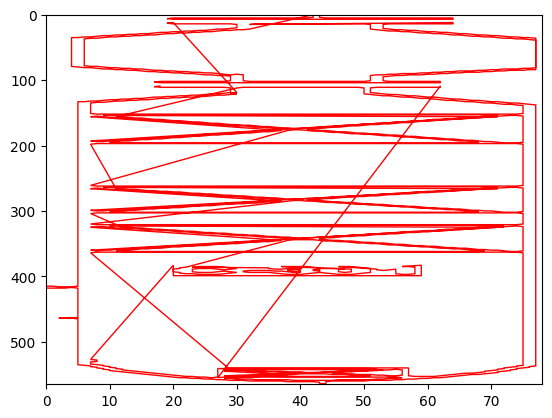

-1

In [156]:
import cv2
import numpy as np
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

img = cv2.imread('tower.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img, contours, -1, (0, 0, 255), 1)

# 提取第一个轮廓的路径数据
path_data = []

# # 遍历 contours 所有的点，将其添加到 path_data 中
for contour in contours:
    for point in contour.squeeze():
        if isinstance(point, np.ndarray) and len(point) == 2:
            path_data.append([point[0], point[1]])

# for contour in contours:
#     hull = cv2.convexHull(contour)
#     for point in hull.squeeze():
#         if isinstance(point, np.ndarray) and len(point) == 2:
#             path_data.append([point[0], point[1]])

# 创建Path2D对象
print(f"contours length: ", len(contours))
print(f"path data length", len(path_data))
print(f"path data: ", path_data)
path = mpath.Path(path_data)

# 绘制路径
fig, ax = plt.subplots()
patch = mpatches.PathPatch(path, facecolor='none', edgecolor='red')
ax.add_patch(patch)
ax.set_xlim(0, img.shape[1])
ax.set_ylim(img.shape[0], 0)
plt.show()

# 绘制路径
# fig, ax = plt.subplots()
# patch = mpatches.PathPatch(path, facecolor='none', edgecolor='red')
# ax.add_patch(patch)
# # 设置图像的宽度和高度比例
# ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), extent=[0, img.shape[1], img.shape[0], 0])
# plt.show()

cv2.imshow("img", img)
cv2.waitKey(0)

31


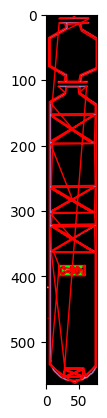

-1

In [132]:
import cv2
import numpy as np
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

img = cv2.imread('tower.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img, contours, -1, (0, 0, 255), 1)

print(len(contours))
# 提取第一个轮廓的路径数据
path_data = []

# 遍历 contours 所有的点，将其添加到 path_data 中
for contour in contours:
    # for point in contour.squeeze():
    #     if isinstance(point, np.ndarray) and len(point) == 2:
    #         path_data.append([point[0], point[1]])
    # 近似轮廓
    epsilon = 0.01 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    for point in approx.squeeze():
        if isinstance(point, np.ndarray) and len(point) == 2:
            path_data.append([point[0], point[1]])

# 创建Path2D对象
path = mpath.Path(path_data)

# 绘制路径
fig, ax = plt.subplots()
patch = mpatches.PathPatch(path, facecolor='none', edgecolor='red')
ax.add_patch(patch)
# 设置图像的宽度和高度比例
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), extent=[0, img.shape[1], img.shape[0], 0])
plt.show()

cv2.imshow("img", img)
cv2.waitKey(0)

11
[[27, 555], [28, 554], [55, 554], [56, 555], [55, 556], [51, 558], [45, 559], [39, 559], [33, 558], [30, 557], [28, 556]]


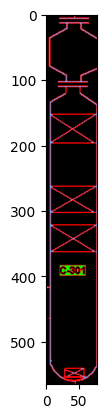

In [149]:
import cv2
import numpy as np
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

img = cv2.imread('tower.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img, contours, -1, (0, 0, 255), 1)

# 提取第一个轮廓的凸包
hull = cv2.convexHull(contours[1])

# 提取凸包的路径数据
path_data = []

# 遍历凸包的点，将其添加到 path_data 中
for point in hull.squeeze():
    if isinstance(point, np.ndarray) and len(point) == 2:
        path_data.append([point[0], point[1]])

print(len(path_data))
print(path_data)
# 创建Path2D对象
path = mpath.Path(path_data)

# 绘制路径
fig, ax = plt.subplots()
patch = mpatches.PathPatch(path, facecolor='none', edgecolor='red')
ax.add_patch(patch)

# 设置图像的宽度和高度比例
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), extent=[0, img.shape[1], img.shape[0], 0])

plt.show()

# cv2.imshow("img", img)
# cv2.waitKey(0)


In [160]:
import cv2
import numpy as np

# 读取图像
image = cv2.imread('tower.png', cv2.IMREAD_GRAYSCALE)

# 使用 Scharr 算子进行边缘检测
edges_x = cv2.Scharr(image, cv2.CV_64F, 1, 0)  # 水平方向
edges_y = cv2.Scharr(image, cv2.CV_64F, 0, 1)  # 垂直方向

# 计算梯度幅值
edges = np.sqrt(edges_x ** 2 + edges_y ** 2)

# 将梯度幅值映射到 0-255 范围内
edges = cv2.normalize(edges, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
print(len(edges))

# 使用Hough变换检测直线
# lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, minLineLength=50, maxLineGap=10)
# for line in lines:
#     x1, y1, x2, y2 = line[0]
#     cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 3)
# 
# print(len(lines))

# 显示结果
cv2.imshow('Scharr Edge Detection', edges)
cv2.waitKey(0)
cv2.destroyAllWindows()


565


In [177]:
import cv2
import numpy as np

# 读取图像
image = cv2.imread('tower.png', cv2.IMREAD_GRAYSCALE)

# 使用 Scharr 算子进行边缘检测
edges_x = cv2.Scharr(image, cv2.CV_64F, 1, 0)  # 水平方向
edges_y = cv2.Scharr(image, cv2.CV_64F, 0, 1)  # 垂直方向

# 计算梯度幅值
edges = np.sqrt(edges_x ** 2 + edges_y ** 2)

# 将梯度幅值映射到 0-255 范围内
edges = cv2.normalize(edges, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# 使用霍夫线变换检测直线
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=1, minLineLength=200, maxLineGap=1)

# 绘制检测到的直线
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

# 显示结果
cv2.imshow('Detected Lines', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [184]:
import cv2
import numpy as np

# 读取图像
# image = cv2.imread('tower.png', cv2.IMREAD_GRAYSCALE)
image = cv2.imread('tower.png', cv2.IMREAD_COLOR)

# 使用 Canny 边缘检测
edges = cv2.Canny(image, 100, 200)

# 使用霍夫线变换检测直线
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=5, minLineLength=1, maxLineGap=2)

# 绘制检测到的直线
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

# 显示结果
cv2.imshow('Detected Lines', image)
cv2.waitKey(0)
cv2.destroyAllWindows()
